In [ ]:
!pip install pykan
!pip install loralib

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import pandas as pd
import yfinance as yf
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, SimpleRNN
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel

from kan import *
import loralib as lora

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Create a directory named 'small_mkt_cap'
os.makedirs('data/small_mkt_cap', exist_ok=True)
os.makedirs('data/sp500', exist_ok=True)
os.makedirs('data/futures', exist_ok=True)

In [ ]:
sp500 = yf.Ticker('^GSPC')
black_berry = yf.Ticker('BB')
home_depot = yf.Ticker('HD')
gold_futures = yf.Ticker('GC=F')


# Small Market Cap Stocks
black_berry.history().to_csv('data/small_mkt_cap/bb.csv', index=False)

# S&P 500 Stocks
sp500.history().to_csv('data/sp500/sp500.csv', index=False)
home_depot.history().to_csv('data/sp500/hd.csv', index=False)

# Futures
gold_futures.history().to_csv('data/futures/gold.csv', index=False)


In [ ]:
bb_data = pd.read_csv('data/small_mkt_cap/bb.csv')['Close'].values.astype(np.float32)


### Volatility Calculation

Our formula for calculating volatility is derived from [Investopedia](https://www.investopedia.com/terms/v/volatility.asp#:~:text=Volatility%20is%20a%20statistical%20measure%20of%20the%20dispersion%20of%20data,prices%2C%20on%20an%20annualized%20basis.) defined as:

$\text{volatility} = \sigma \sqrt{T}$

Volatility will be used as a indicator for the amount of noise to add to our model for price forecasting using a KAN as a backbone.

In [ ]:
def calculate_volatility_index(data, window=30, trading_days_per_year=252):
    # Calculate daily returns
    daily_returns = data['Adj Close'].pct_change() * 100

    # Calculate rolling volatility (30-day window)
    volatility = daily_returns.rolling(window=window).std() * np.sqrt(trading_days_per_year)

    return volatility

#### KAN Example

Bwloe shows usage of a KAN where we use a stocks open and volume data to predict the closing price. The first parameter defines how many input features we are using

checkpoint directory created: ./model
saving model version 0.0
torch.Size([16, 2]) torch.Size([16])
torch.Size([4, 2]) torch.Size([4])


| train_loss: 1.12e+00 | test_loss: 8.65e-01 | reg: 1.44e+01 | : 100%|█| 20/20 [00:01<00:00, 10.04it


saving model version 0.1


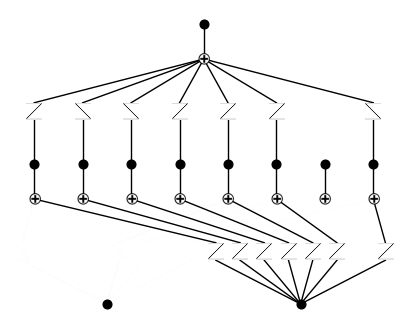

In [ ]:
model = KAN(width=[2,8,1], grid=3, k=3, device=device)

datapoints_data = pd.read_csv('data/small_mkt_cap/bb.csv')[['Open', 'Volume']].values.astype(np.float32)
labels_data = pd.read_csv('data/small_mkt_cap/bb.csv')['Close'].values.astype(np.float32)

train_input = torch.tensor(datapoints_data[:int(0.8*len(datapoints_data)), :])
test_input = torch.tensor(datapoints_data[int(0.8*len(datapoints_data)):, :])

train_label = torch.tensor(labels_data[:int(0.8*len(datapoints_data))])
test_label = torch.tensor(labels_data[int(0.8*len(datapoints_data)):])

print(train_input.shape, train_label.shape)
print(test_input.shape, test_label.shape)
dataset = {}
dataset['train_input'] = train_input.to(device)
dataset['test_input'] = test_input.to(device)

dataset['train_label'] = train_label.to(device)
dataset['test_label'] = test_label.to(device)

model.fit(dataset, opt="LBFGS", steps=20)
model.plot()


[*********************100%***********************]  1 of 1 completed


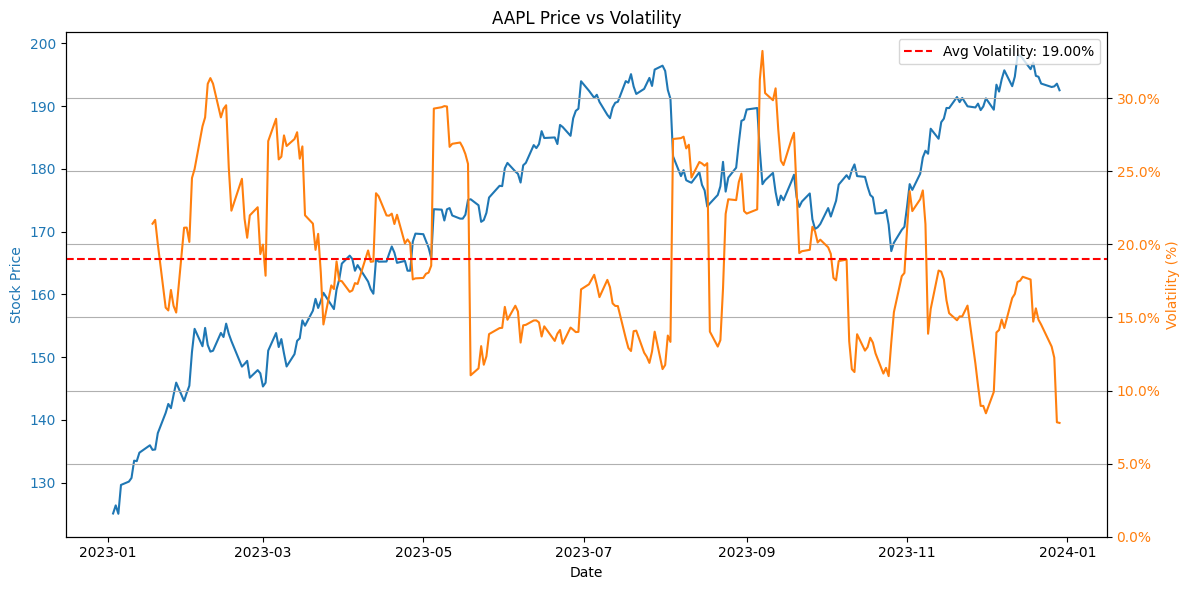

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to fetch and prepare data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Set parameters
ticker = 'IWC'
start_date = '2023-01-01'
end_date = '2023-12-31'
seq_length = 10

# Fetch and prepare data
data = fetch_stock_data(ticker, start_date, end_date)
close_prices = data['Close'].values.reshape(-1, 1)

# Calculate volatility (to be used by LoRA)
volatility = calculate_volatility_index(data, window=seq_length)

average_volatility = np.mean(volatility)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot close prices on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color=color)
ax1.plot(data.index, close_prices, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Volatility (%)', color=color)
ax2.plot(data.index, volatility, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add horizontal line for average volatility
ax2.axhline(y=average_volatility, color='red', linestyle='--', label=f'Avg Volatility: {average_volatility:.2f}%')

# Format y-axis as percentage
def percentage(x, pos):
    return f'{x:.1f}%'

ax2.yaxis.set_major_formatter(plt.FuncFormatter(percentage))

# Adjust the volatility axis limits to appear below the stock price
ax1_min, ax1_max = ax1.get_ylim()
ax2_min, ax2_max = ax2.get_ylim()
ax2.set_ylim(0, min(ax2_max, ax1_min))

plt.title(f'{ticker} Price vs Volatility')
plt.grid(True)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

### Baselines
#### LSTM
#### RNN
#### MLP

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

def build_mlp_model(seq_length):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(seq_length, 1)),
        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

def build_rnn_model(seq_length):
    model = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.5),
        SimpleRNN(64),
        Dropout(0.5),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

def forecast_prices(model, last_sequence, scaler, num_days):
    forecasted_prices = []
    current_sequence = last_sequence.copy()

    for _ in range(num_days):
        current_sequence_reshaped = np.reshape(current_sequence, (1, current_sequence.shape[0], 1))
        next_price = model.predict(current_sequence_reshaped)
        forecasted_prices.append(next_price[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_price

    forecasted_prices = scaler.inverse_transform(np.array(forecasted_prices).reshape(-1, 1))
    return forecasted_prices

ticker = 'IWC'
start_date = '2023-01-01'
end_date = '2023-12-31'
seq_length = 60
num_runs = 5

data = fetch_stock_data(ticker, start_date, end_date)
close_prices = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

train_data, test_data = train_test_split(scaled_data, test_size=0.25, shuffle=False)
forecast_length = len(test_data)

X_train, y_train = create_sequences(train_data, seq_length)

results = {
    'LSTM': [],
    'MLP': [],
    'RNN': []
}

lstm_trian_times = []
mlp_train_times = []
rnn_train_times = []

lstm_predict_times = []
mlp_predict_times = []
rnn_predict_times = []

for _ in range(num_runs):
    for model_name in ['LSTM', 'MLP', 'RNN']:
        if model_name == 'LSTM':
            model = build_lstm_model(seq_length)

            # Begin train time
            start = time.time()
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            end = time.time()
            lstm_trian_times.append(end - start)

            # Begin test time
            start = time.time()
            test_predict = forecast_prices(model, X_train[-1], scaler, forecast_length)
            end = time.time()
            lstm_predict_times.append(end - start)
        elif model_name == 'MLP':
            model = build_mlp_model(seq_length)
            start = time.time()
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            end = time.time()
            mlp_train_times.append(end - start)

            # Begin test time
            start = time.time()
            test_predict = forecast_prices(model, X_train[-1], scaler, forecast_length)
            end = time.time()
            mlp_predict_times.append(end - start)
        else:
            model = build_rnn_model(seq_length)
            start = time.time()
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            end = time.time()
            rnn_train_times.append(end - start)

            # Begin test time
            start = time.time()
            test_predict = forecast_prices(model, X_train[-1], scaler, forecast_length)
            end = time.time()
            rnn_predict_times.append(end - start)



        results[model_name].append(test_predict)

print(f'LSTM Train Time: {np.mean(lstm_trian_times)}')
print(f'MLP Train Time: {np.mean(mlp_train_times)}')
print(f'RNN Train Time: {np.mean(rnn_train_times)}')

print(f'LSTM Predict Time: {np.mean(lstm_predict_times)}')
print(f'MLP Predict Time: {np.mean(mlp_predict_times)}')
print(f'RNN Predict Time: {np.mean(rnn_predict_times)}')

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

#### Plotting


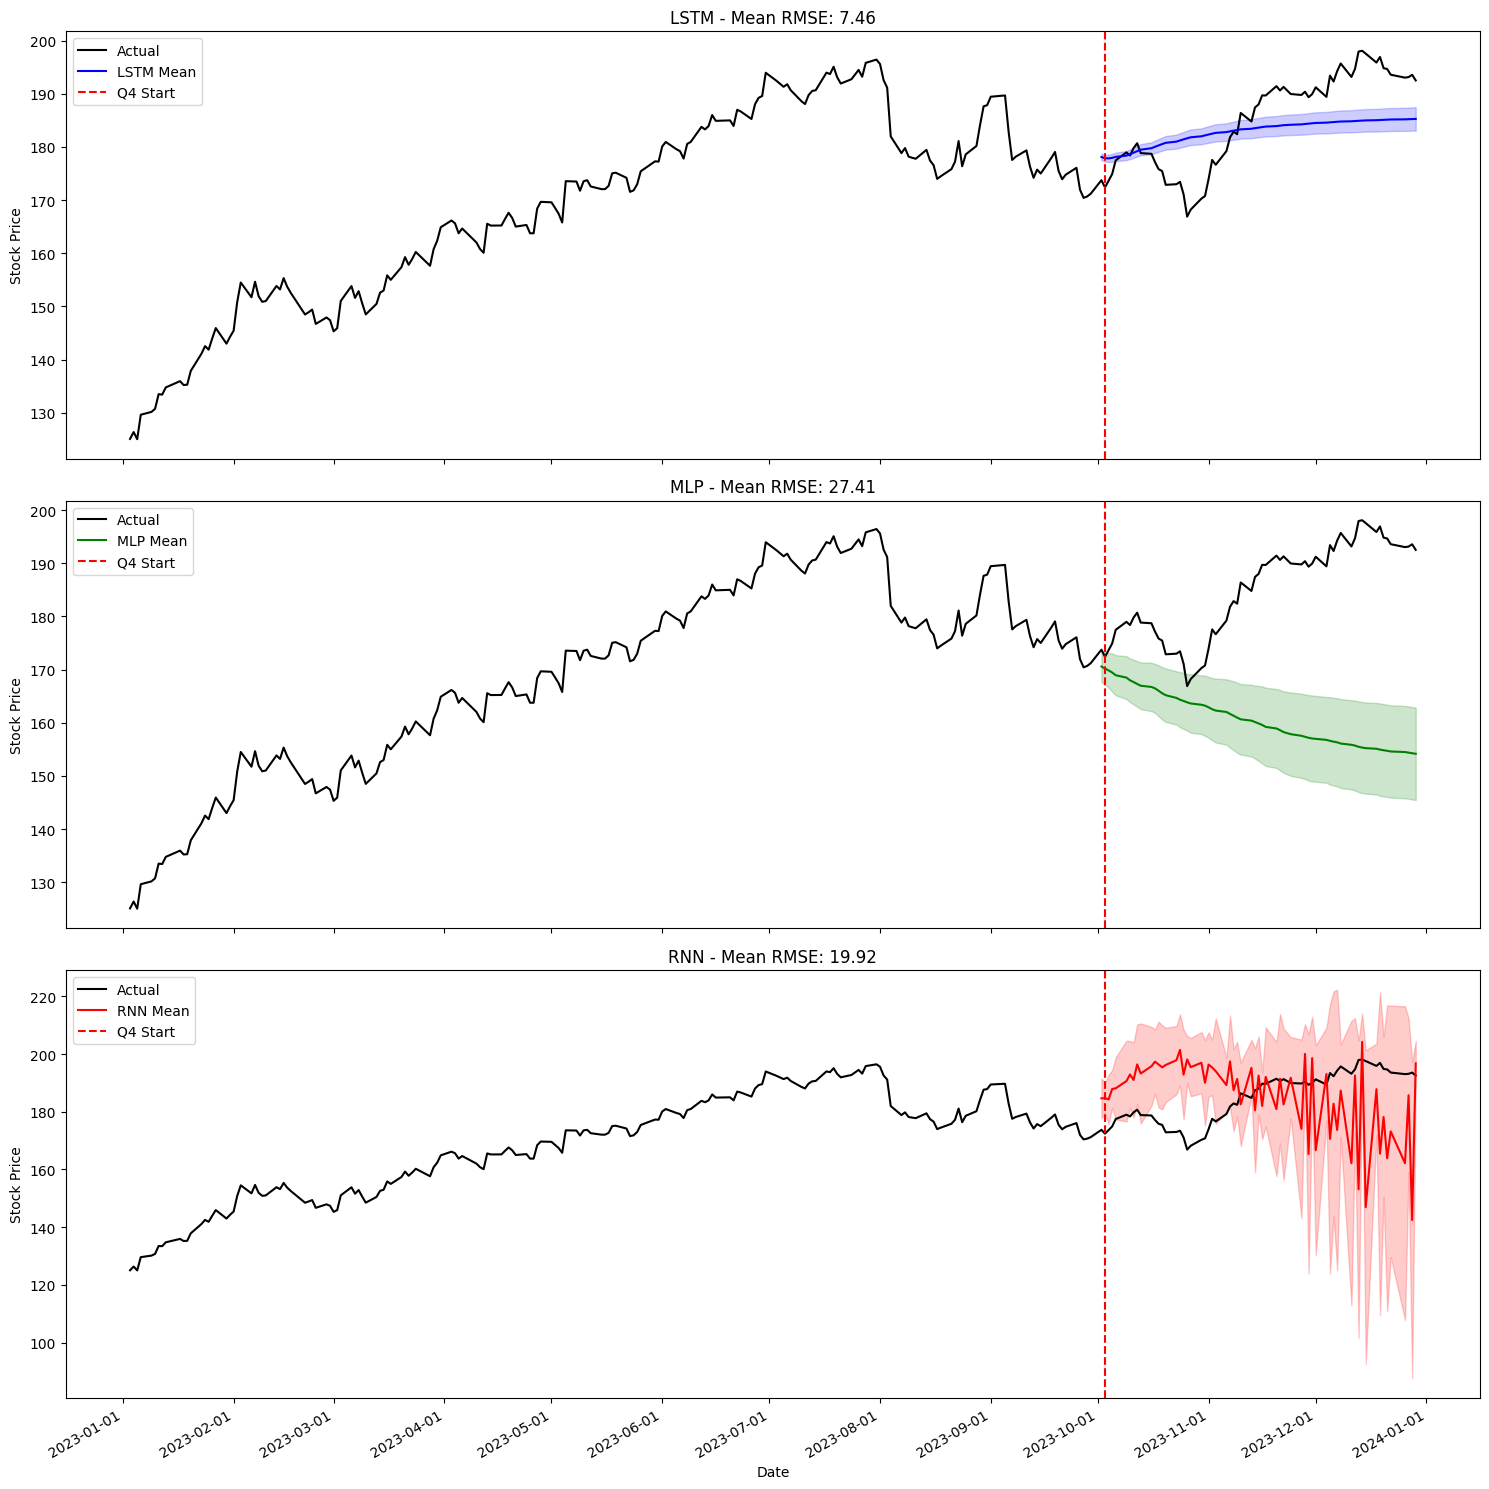

In [ ]:
# Calculate mean and standard deviation
mean_results = {}
std_results = {}
for model_name in results:
    mean_results[model_name] = np.mean(results[model_name], axis=0)
    std_results[model_name] = np.std(results[model_name], axis=0)

# Plotting
plt.figure(figsize=(15, 15))
colors = {'LSTM': 'blue', 'MLP': 'green', 'RNN': 'red'}

q4_start_date = np.datetime64('2023-10-03')

for i, model_name in enumerate(['LSTM', 'MLP', 'RNN']):
    plt.subplot(3, 1, i+1)

    # Stock prices
    plt.plot(data.index, close_prices, label='Actual', color='black')

    # mean forecast
    plt.plot(data.index[-forecast_length:], mean_results[model_name],
             label=f'{model_name} Mean', color=colors[model_name])

    # stdev forecast
    plt.fill_between(data.index[-forecast_length:],
                     mean_results[model_name].flatten() - std_results[model_name].flatten(),
                     mean_results[model_name].flatten() + std_results[model_name].flatten(),
                     color=colors[model_name], alpha=0.2)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((mean_results[model_name] - close_prices[-forecast_length:])**2))
    plt.title(f'{model_name} - Mean RMSE: {rmse:.2f}')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.axvline(x=q4_start_date, color='red', linestyle='--', label='Q4 Start')
    plt.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

### KAN Implementation

**Important note:** Pykan requires a [train and test](https://github.com/KindXiaoming/pykan/issues/391) to fit the model, so we create a validation set to fit the model 😀

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
===IMPORTANT===
We are discarding the test data as usual, because the forecast is used for test

This is kind of confusing, but the split is defined as:

TRAIN             | TEST
1 2 3 4 5 6 7 8 9 | 10 11 12

VALIDATION | TEST
1 2 3 4 5  | 6 7 8 9

Then we use test as the validation set here to satisfy the KAN's dataset requirement for fitting the model
The dataset is NOT poisined!! :)
'''
train_data, test_data = train_test_split(scaled_data, test_size=0.25, shuffle=False)
validation_data, test_data = train_test_split(train_data, test_size=0.5, shuffle=False)

X_train, y_train = create_sequences(train_data, seq_length)
X_validation, y_validation = create_sequences(test_data, seq_length)

X_train, y_train = torch.tensor(X_train.squeeze(-1).astype(np.float32)).to(device), torch.tensor(y_train.squeeze(-1).astype(np.float32)).to(device)
X_validation, y_validation = torch.tensor(X_validation.squeeze(-1).astype(np.float32)).to(device), torch.tensor(y_validation.squeeze(-1).astype(np.float32)).to(device)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

def build_kan_model(seed=1):
    model = KAN(width=[seq_length,3,1], grid=35, k=1,seed=seed, auto_save=False, device=device)
    dataset = {}
    dataset['train_input'] = X_train
    dataset['train_label'] = y_train

    dataset['test_input'] = X_validation
    dataset['test_label'] = y_validation

    model.fit(dataset, opt="LBFGS", steps=10)

    return model

# kan_model = build_kan_model()
# kan_model.plot()
# print(kan_model.forward(validation_data[-1]).detach())

torch.Size([127, 60]) torch.Size([127])
torch.Size([34, 60]) torch.Size([34])


In [ ]:
def forecast_prices_kan(model, last_sequence, scaler, num_days, rands):
    forecasted_prices = []
    current_sequence = last_sequence.clone().detach()

    with torch.no_grad():
        for i in range(num_days):
            current_sequence_reshaped = current_sequence.view(1, current_sequence.shape[0])
            next_price = model(current_sequence_reshaped)
            forecasted_prices.append(next_price.item())

            current_sequence = torch.roll(current_sequence, shifts=-1) + rands[i]
            current_sequence[-1] = next_price.squeeze()

    forecasted_prices_np = np.array(forecasted_prices).reshape(-1, 1)
    forecasted_prices = scaler.inverse_transform(forecasted_prices_np)

    return forecasted_prices

#### Plotting

| train_loss: 1.38e-01 | test_loss: 1.11e-01 | reg: 2.24e+01 | : 100%|█| 10/10 [00:01<00:00,  5.53it
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at .

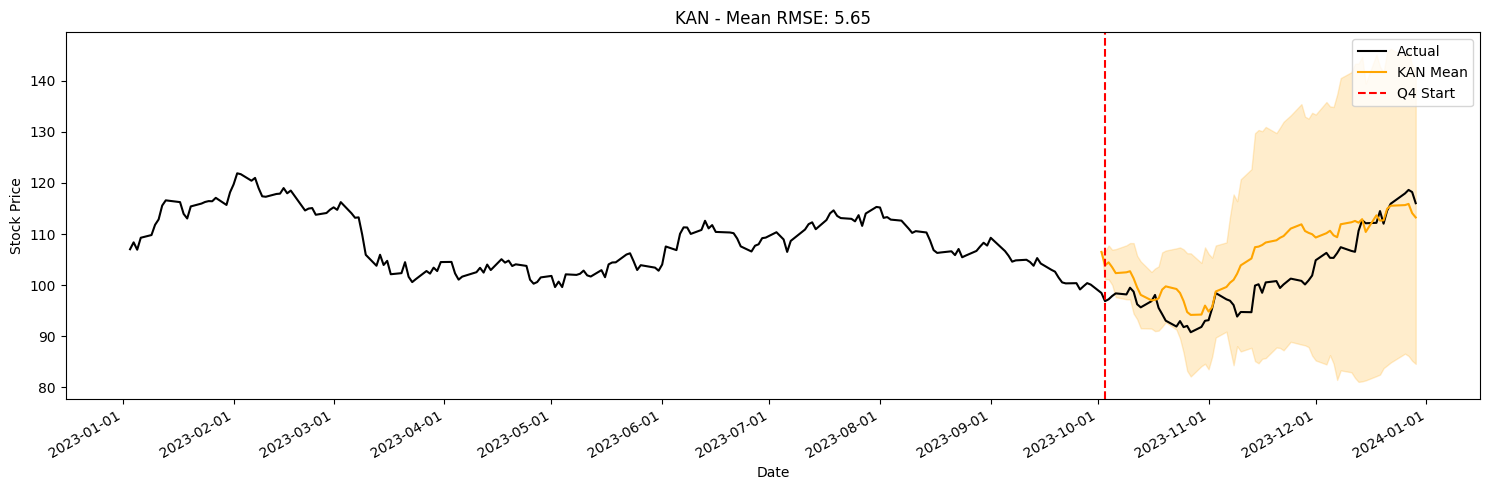

KAN Train Time: 2.7635093688964845
KAN Predict Time: 4.138077449798584


In [ ]:
KAN_results = []
NOISE = 0.1
# bias = 2

kan_train_times = []
kan_predict_times = []

# fit the kan model
for i in range(num_runs):
    begin_kan_train = time.time()
    model = build_kan_model(i)
    kan_train_times.append(time.time() - begin_kan_train)


    # for some reason random doesn't generate random sequences within the loop
    torch.manual_seed(i)
    rands = torch.randn(forecast_length).to(device) * torch.tensor(NOISE).to(device)

    begin_kan_predict = time.time()
    with torch.no_grad():
      test_predict = forecast_prices_kan(model, X_validation[-1], scaler, forecast_length, rands)
    kan_predict_times.append(time.time() - begin_kan_predict)

    KAN_results.append(test_predict)

# calculate results
kan_mean_results = np.mean(KAN_results, axis=0)
kan_std_results = np.std(KAN_results, axis=0)

plt.figure(figsize=(15, 5))


plt.plot(data.index, close_prices, label='Actual', color='black')
plt.plot(data.index[-forecast_length:], kan_mean_results,
          label=f'KAN Mean', color='orange')
plt.fill_between(data.index[-forecast_length:],
                  kan_mean_results.flatten() - kan_std_results.flatten(),
                  kan_mean_results.flatten() + kan_std_results.flatten(),
                  color='orange', alpha=0.2)
rmse = np.sqrt(np.mean((kan_mean_results - close_prices[-forecast_length:])**2))
plt.title(f'KAN - Mean RMSE: {rmse:.2f}')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.axvline(x=q4_start_date, color='red', linestyle='--', label='Q4 Start')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

print(f'KAN Train Time: {np.mean(kan_train_times)}')
print(f'KAN Predict Time: {np.mean(kan_predict_times)}')

### KAN + LoRA Implementation

In [ ]:
'''
===IMPORTANT===
We are discarding the test data as usual, because the forecast is used for test

This is kind of confusing, but the split is defined as:

TRAIN             | TEST
1 2 3 4 5 6 7 8 9 | 10 11 12

VALIDATION | TEST
1 2 3 4 5  | 6 7 8 9

Then we use test as the validation set here to satisfy the KAN's dataset requirement for fitting the model
The dataset is NOT poisined!! :)
'''
train_data, test_data = train_test_split(scaled_data, test_size=0.25, shuffle=False)
validation_data, test_data = train_test_split(train_data, test_size=0.5, shuffle=False)

X_train, y_train = create_sequences(train_data, seq_length)
X_validation, y_validation = create_sequences(test_data, seq_length)

X_train, y_train = torch.tensor(X_train.squeeze(-1).astype(np.float32)).to(device), torch.tensor(y_train.squeeze(-1).astype(np.float32)).to(device)
X_validation, y_validation = torch.tensor(X_validation.squeeze(-1).astype(np.float32)).to(device), torch.tensor(y_validation.squeeze(-1).astype(np.float32)).to(device)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

torch.Size([127, 60]) torch.Size([127])
torch.Size([34, 60]) torch.Size([34])


In [ ]:
def build_klara_model(seed=1):
    model = KAN(width=[seq_length,3,1], grid=35, k=1,seed=seed, auto_save=False, device=device)
    dataset = {}
    dataset['train_input'] = X_train
    dataset['train_label'] = y_train

    dataset['test_input'] = X_validation
    dataset['test_label'] = y_validation

    train_start = time.time()
    model.fit(dataset, opt="LBFGS", steps=10)
    train_end = time.time()
    Lora_KAN_train_time = train_end - train_start

    return model, Lora_KAN_train_time

kan_model, kan_train_time = build_klara_model()

class Lora_KAN(nn.Module):
    def __init__(self, kan_model, rank=16):
        super(Lora_KAN, self).__init__()
        self.kan_model = kan_model
        self.lora_layer = lora.Linear(seq_length, 1, r=rank)

    def forward(self, x):
        kan_output = self.kan_model(x)
        lora_output = self.lora_layer(x)
        return kan_output + lora_output

lora_kan = Lora_KAN(kan_model)
lora_kan.to(device)
lora.mark_only_lora_as_trainable(lora_kan)


| train_loss: 1.39e-01 | test_loss: 1.11e-01 | reg: 1.74e+01 | : 100%|█| 10/10 [00:03<00:00,  3.28it


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Build volatility dataset until Q4
q4_start = '2023-10-01'
vol_train_data = volatility[volatility.index < q4_start].dropna().values.reshape(-1, 1)
vol_test_data = volatility[volatility.index >= q4_start]

lora_x_train, lora_y_train = create_sequences(vol_train_data, seq_length)
optimizer = torch.optim.Adam(lora_kan.parameters(), lr=0.01)
criterion = nn.MSELoss()

volatility_batch_loader = DataLoader(list(zip(lora_x_train, lora_y_train)), batch_size=32, shuffle=True)

# Train Klara
start_klara_train = time.time()
for vol_x_train, vol_y_train in volatility_batch_loader:
    optimizer.zero_grad()
    vol_x_train = torch.tensor(vol_x_train.squeeze(-1)).to(torch.float32).to(device)
    vol_y_train = torch.tensor(vol_y_train.squeeze(-1)).to(torch.float32).to(device)
    output = lora_kan(vol_x_train)
    loss = criterion(output, vol_y_train)
    loss.backward()
    optimizer.step()
KARLA_train_time = time.time() - start_klara_train


Lora_KAN_results = []
Lora_KAN_forecast_time = []
NOISE = 0.1

# Evaluate Klara
for i in range(num_runs):

    # For some reason random doesn't generate random sequences within the loop
    torch.manual_seed(i)
    rands = torch.randn(forecast_length).to(device) * torch.tensor(NOISE).to(device)
    start = time.time()
    with torch.no_grad():
      test_predict = forecast_prices_kan(lora_kan, X_validation[-1], scaler, forecast_length, rands)
    end = time.time()
    Lora_KAN_forecast_time.append(end - start)
    Lora_KAN_results.append(test_predict)

<ipython-input-126-7af7a1f0b063>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_x_train = torch.tensor(vol_x_train.squeeze(-1)).to(torch.float32).to(device)
<ipython-input-126-7af7a1f0b063>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_y_train = torch.tensor(vol_y_train.squeeze(-1)).to(torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.

In [ ]:
print(f'KARLA Train Time: {KARLA_train_time}')
print(f'KARLA Forecast Time: {np.mean(Lora_KAN_forecast_time)}')

KARLA Train Time: 0.22396230697631836
KARLA Forecast Time: 3.3504507064819338


In [ ]:
print(lora_kan)

Lora_KAN(
  (kan_model): MultKAN(
    (act_fun): ModuleList(
      (0-1): 2 x KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun): SiLU()
    (symbolic_fun): ModuleList(
      (0-1): 2 x Symbolic_KANLayer()
    )
  )
  (lora_layer): Linear(in_features=60, out_features=1, bias=True)
)


#### Plotting

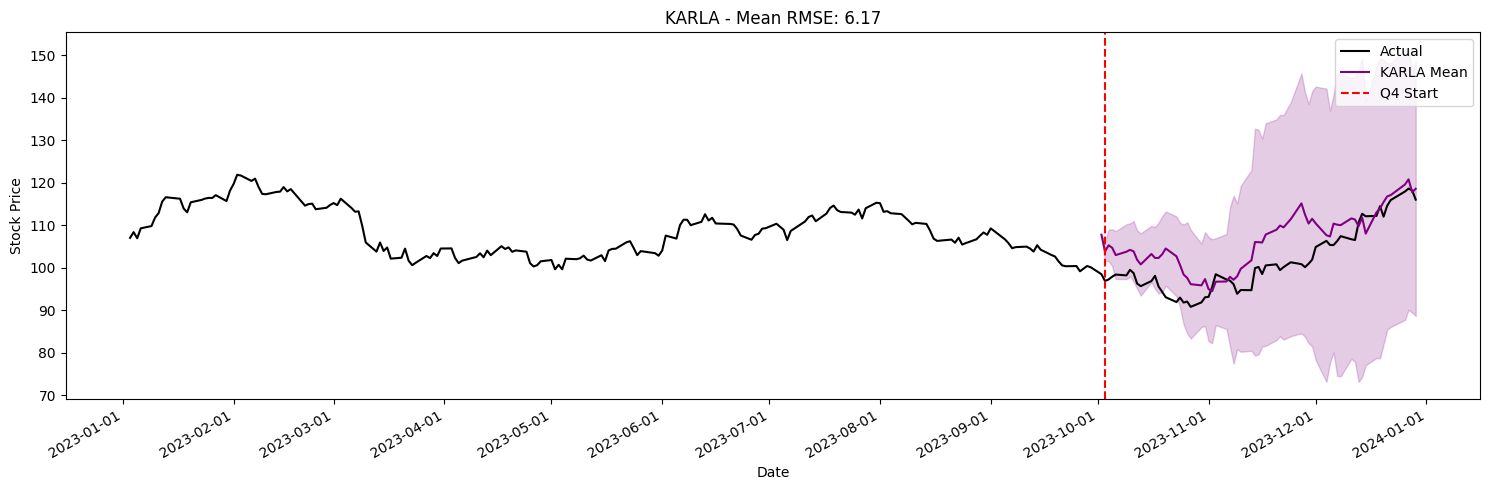

In [ ]:
# Calculate mean and standard deviation
kan_mean_results = np.mean(Lora_KAN_results, axis=0)
kan_std_results = np.std(Lora_KAN_results, axis=0)

plt.figure(figsize=(15, 5))


# Stock prices
plt.plot(data.index, close_prices, label='Actual', color='black')

# Mean forecast
plt.plot(data.index[-forecast_length:], kan_mean_results,
          label=f'KARLA Mean', color='purple')

# Stdev forecast
plt.fill_between(data.index[-forecast_length:],
                  kan_mean_results.flatten() - kan_std_results.flatten(),
                  kan_mean_results.flatten() + kan_std_results.flatten(),
                  color='purple', alpha=0.2)

# Calculate RMSE
rmse = np.sqrt(np.mean((kan_mean_results - close_prices[-forecast_length:])**2))
plt.title(f'KARLA - Mean RMSE: {rmse:.2f}')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.axvline(x=q4_start_date, color='red', linestyle='--', label='Q4 Start')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

### BERT

In [ ]:
'''
Build a bert model to forecast price
'''
class ForecastBert(nn.Module):
  def __init__(self):
    super(ForecastBert, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.representation = nn.Linear(768, 50)
    self.prediction = nn.Linear(50, 1)

  def forward(self, x):
    sequence_output, pooled_output = self.bert(x, return_dict=False)
    x = sequence_output[:,0,:].view(-1,768)
    x = self.representation(x)
    x = self.prediction(x)
    return x

In [ ]:
bert_forecaster = ForecastBert()
bert_forecaster.to(device)
bert_forecaster.parameters()

<generator object Module.parameters at 0x79ef23ebed50>

In [ ]:
def quantize(input_vector, num_levels=30000):
        min_val = np.min(input_vector)
        max_val = np.max(input_vector)
        # Create quantization levels
        levels = np.linspace(min_val, max_val, num_levels)
        # Digitize the input vector to quantize
        quantized_vector = np.digitize(input_vector, levels) - 1  # Adjust for zero indexing
        return quantized_vector.squeeze(-1), levels

def forecast_prices_bert(model, last_sequence, scaler, num_days, quantize_levels):
    forecasted_prices = []
    current_sequence = last_sequence.clone().detach().cpu()

    for _ in range(num_days):
        current_sequence_reshaped = torch.tensor(np.reshape(current_sequence, (1, current_sequence.shape[0]))).to(device)
        print(current_sequence)
        next_price = np.digitize(model(current_sequence_reshaped).cpu(), quantize_levels) - 1
        print(next_price)

        forecasted_prices.append(next_price[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_price
    inv_quant_scaler = MinMaxScaler()

    # Reshape quantized_vector for scaling (2D array)
    quantized_vector_reshaped = np.array(forecasted_prices).reshape(-1, 1)
    normalized_vector = inv_quant_scaler.fit_transform(quantized_vector_reshaped)
    print(forecasted_prices)
    return forecasted_prices


train_data, test_data = train_test_split(scaled_data, test_size=0.25, shuffle=False)

X_train, Y_train = create_sequences(train_data, seq_length)
X_train, quantize_levels = quantize(X_train)

price_batch_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=1, shuffle=True)


optimizer = torch.optim.Adam(bert_forecaster.parameters(), lr=0.002)
criterion = nn.MSELoss()


# Train Bert Forecaster
bert_forecaster.train()
start_bert_forecaster_train = time.time()
for x_train, y_train in price_batch_loader:
    optimizer.zero_grad()
    x_train = torch.tensor(x_train).to(device).long()
    y_train = torch.tensor(y_train.squeeze(-1)).to(torch.float32).to(device)
    output = bert_forecaster(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
bert_forecaster_train_time = time.time() - start_bert_forecaster_train


BertForecaster_results = []
BertForecaster_forecast_time = []

# Evaluate Bert Forecaster
bert_forecaster.eval()
for i in range(num_runs):

    # For some reason random doesn't generate random sequences within the loop
    torch.manual_seed(i)
    start = time.time()
    with torch.no_grad():
      bert_input = torch.tensor(X_train[-1]).to(device).long()
      # print(bert_input.shape)
      test_predict = forecast_prices_bert(bert_forecaster, bert_input, scaler, forecast_length, quantize_levels)
    end = time.time()
    BertForecaster_forecast_time.append(end - start)
    BertForecaster_results.append(test_predict)

<ipython-input-132-6b0f30348393>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).to(device).long()
<ipython-input-132-6b0f30348393>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train.squeeze(-1)).to(torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
<ipython-input-132-6b0f30348393>:15: UserWarning: To copy constr

tensor([ 9700, 12538, 14768, 15481, 16867, 17342, 15560, 17936, 19664, 20430,
        18991, 18437, 18239, 17592, 19189, 16418, 19612, 21314, 21169, 18490,
        18688, 18041, 17777, 16774, 15731, 14610, 15058, 14715, 12670, 10162,
         9436,  9555,  9858,  8869, 10452,  8314,  8750,  9951, 11059, 12062,
        11337, 13343,  9911,  8697,  7179,  7509,  7668,  7087,  6123,  8103,
         6704,  5068,  4592,  3075,  1821,  1570,  1623,     0,   844,  1636])
[[6246]]
[12538 14768 15481 16867 17342 15560 17936 19664 20430 18991 18437 18239
 17592 19189 16418 19612 21314 21169 18490 18688 18041 17777 16774 15731
 14610 15058 14715 12670 10162  9436  9555  9858  8869 10452  8314  8750
  9951 11059 12062 11337 13343  9911  8697  7179  7509  7668  7087  6123
  8103  6704  5068  4592  3075  1821  1570  1623     0   844  1636  6246]
[[6246]]
[14768 15481 16867 17342 15560 17936 19664 20430 18991 18437 18239 17592
 19189 16418 19612 21314 21169 18490 18688 18041 17777 16774 15731 14610
 

<ipython-input-132-6b0f30348393>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence_reshaped = torch.tensor(np.reshape(current_sequence, (1, current_sequence.shape[0]))).to(device)
<ipython-input-132-6b0f30348393>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1] = next_price


[[6246]]
[18239 17592 19189 16418 19612 21314 21169 18490 18688 18041 17777 16774
 15731 14610 15058 14715 12670 10162  9436  9555  9858  8869 10452  8314
  8750  9951 11059 12062 11337 13343  9911  8697  7179  7509  7668  7087
  6123  8103  6704  5068  4592  3075  1821  1570  1623     0   844  1636
  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246]
[[6246]]
[17592 19189 16418 19612 21314 21169 18490 18688 18041 17777 16774 15731
 14610 15058 14715 12670 10162  9436  9555  9858  8869 10452  8314  8750
  9951 11059 12062 11337 13343  9911  8697  7179  7509  7668  7087  6123
  8103  6704  5068  4592  3075  1821  1570  1623     0   844  1636  6246
  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246]
[[6246]]
[19189 16418 19612 21314 21169 18490 18688 18041 17777 16774 15731 14610
 15058 14715 12670 10162  9436  9555  9858  8869 10452  8314  8750  9951
 11059 12062 11337 13343  9911  8697  7179  7509  7668  7087  6123  8103
  6704  5068  4592  30

<ipython-input-132-6b0f30348393>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence_reshaped = torch.tensor(np.reshape(current_sequence, (1, current_sequence.shape[0]))).to(device)
<ipython-input-132-6b0f30348393>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1] = next_price


[[6246]]
[18991 18437 18239 17592 19189 16418 19612 21314 21169 18490 18688 18041
 17777 16774 15731 14610 15058 14715 12670 10162  9436  9555  9858  8869
 10452  8314  8750  9951 11059 12062 11337 13343  9911  8697  7179  7509
  7668  7087  6123  8103  6704  5068  4592  3075  1821  1570  1623     0
   844  1636  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246]
[[6246]]
[18437 18239 17592 19189 16418 19612 21314 21169 18490 18688 18041 17777
 16774 15731 14610 15058 14715 12670 10162  9436  9555  9858  8869 10452
  8314  8750  9951 11059 12062 11337 13343  9911  8697  7179  7509  7668
  7087  6123  8103  6704  5068  4592  3075  1821  1570  1623     0   844
  1636  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246  6246]
[[6246]]
[18239 17592 19189 16418 19612 21314 21169 18490 18688 18041 17777 16774
 15731 14610 15058 14715 12670 10162  9436  9555  9858  8869 10452  8314
  8750  9951 11059 12062 11337 13343  9911  8697  7179  7509  7668  7087
  6123  8103  6704  50

<ipython-input-132-6b0f30348393>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence_reshaped = torch.tensor(np.reshape(current_sequence, (1, current_sequence.shape[0]))).to(device)
<ipython-input-132-6b0f30348393>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1] = next_price


[[6246]]
[17342 15560 17936 19664 20430 18991 18437 18239 17592 19189 16418 19612
 21314 21169 18490 18688 18041 17777 16774 15731 14610 15058 14715 12670
 10162  9436  9555  9858  8869 10452  8314  8750  9951 11059 12062 11337
 13343  9911  8697  7179  7509  7668  7087  6123  8103  6704  5068  4592
  3075  1821  1570  1623     0   844  1636  6246  6246  6246  6246  6246]
[[6246]]
[15560 17936 19664 20430 18991 18437 18239 17592 19189 16418 19612 21314
 21169 18490 18688 18041 17777 16774 15731 14610 15058 14715 12670 10162
  9436  9555  9858  8869 10452  8314  8750  9951 11059 12062 11337 13343
  9911  8697  7179  7509  7668  7087  6123  8103  6704  5068  4592  3075
  1821  1570  1623     0   844  1636  6246  6246  6246  6246  6246  6246]
[[6246]]
[17936 19664 20430 18991 18437 18239 17592 19189 16418 19612 21314 21169
 18490 18688 18041 17777 16774 15731 14610 15058 14715 12670 10162  9436
  9555  9858  8869 10452  8314  8750  9951 11059 12062 11337 13343  9911
  8697  7179  7509  76

<ipython-input-132-6b0f30348393>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence_reshaped = torch.tensor(np.reshape(current_sequence, (1, current_sequence.shape[0]))).to(device)
<ipython-input-132-6b0f30348393>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1] = next_price


[[6246]]
[16867 17342 15560 17936 19664 20430 18991 18437 18239 17592 19189 16418
 19612 21314 21169 18490 18688 18041 17777 16774 15731 14610 15058 14715
 12670 10162  9436  9555  9858  8869 10452  8314  8750  9951 11059 12062
 11337 13343  9911  8697  7179  7509  7668  7087  6123  8103  6704  5068
  4592  3075  1821  1570  1623     0   844  1636  6246  6246  6246  6246]
[[6246]]
[17342 15560 17936 19664 20430 18991 18437 18239 17592 19189 16418 19612
 21314 21169 18490 18688 18041 17777 16774 15731 14610 15058 14715 12670
 10162  9436  9555  9858  8869 10452  8314  8750  9951 11059 12062 11337
 13343  9911  8697  7179  7509  7668  7087  6123  8103  6704  5068  4592
  3075  1821  1570  1623     0   844  1636  6246  6246  6246  6246  6246]
[[6246]]
[15560 17936 19664 20430 18991 18437 18239 17592 19189 16418 19612 21314
 21169 18490 18688 18041 17777 16774 15731 14610 15058 14715 12670 10162
  9436  9555  9858  8869 10452  8314  8750  9951 11059 12062 11337 13343
  9911  8697  7179  75

In [ ]:
print(f'Bert Forecaster Train Time: {bert_forecaster_train_time}')
print(f'Bert Forecaster Forecast Time: {np.mean(BertForecaster_forecast_time)}')

Bert Forecaster Train Time: 11.244874954223633
Bert Forecaster Forecast Time: 1.445098352432251


In [ ]:
# Calculate mean and standard deviation
bert_mean_results = np.mean(final_prices, axis=0)
bert_std_results = np.std(final_prices, axis=0)

plt.figure(figsize=(15, 5))


# Stock prices
plt.plot(data.index, close_prices, label='Actual', color='black')

# Mean forecast
plt.plot(data.index[-forecast_length:], bert_mean_results,
          label=f'KARLA Mean', color='purple')

# Stdev forecast
plt.fill_between(data.index[-forecast_length:],
                  bert_mean_results.flatten() - bert_std_results.flatten(),
                  bert_mean_results.flatten() + bert_std_results.flatten(),
                  color='purple', alpha=0.2)

# Calculate RMSE
rmse = np.sqrt(np.mean((bert_mean_results - close_prices[-forecast_length:])**2))
plt.title(f'KARLA - Mean RMSE: {rmse:.2f}')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.axvline(x=q4_start_date, color='red', linestyle='--', label='Q4 Start')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

NameError: name 'final_prices' is not defined